This repository contains a stand-alone approach for detecting cars in videos captured while driving on highways; Udacity's Self-Driving Car degree project 5: Vehicle Detection.
Many of its code is based on in-class examples and assigments.

In [2]:
# Import as usual
from moviepy.editor import VideoFileClip
from IPython.display import HTML

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV
from scipy.ndimage.measurements import label
from sklearn.utils import shuffle
from skimage.feature import hog
from sklearn import svm

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
import copy
import time
import pickle
import cv2
import glob
import random

# for auto reloading the Utils functions
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Training
### Load and preprocess data sets

Only necessary for training, not for inference/testing

Data from the [GTI](http://www.gti.ssr.upm.es/data/Vehicle_database.html) and [KITTI](http://www.cvlibs.net/datasets/kitti/) databases.

# number of vehicle pictures: 1196
# number of non-vehicle pictures: 1125
Total number of pictures: 2321


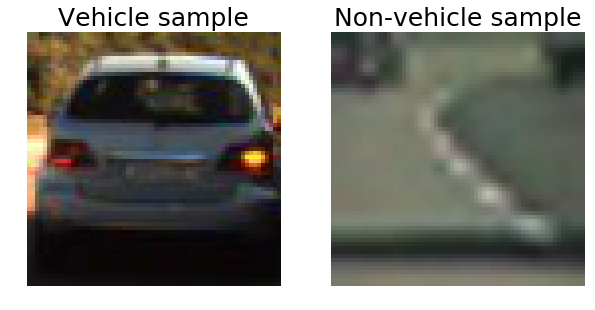

In [51]:
# load in all the training data
load_small = True # for prototyping

if load_small:
    vehicle_files = glob.glob('data/vehicles_smallset/*')
    non_veh_files = glob.glob('data/non-vehicles_smallset/*')
else:
    vehicle_files = glob.glob('data/vehicles/KITTI_extracted/*')
    vehicle_files.extend(glob.glob('data/vehicles/GTI_Far/*'))
    vehicle_files.extend(glob.glob('data/vehicles/GTI_Left/*'))
    vehicle_files.extend(glob.glob('data/vehicles/GTI_MiddleClose/*'))
    vehicle_files.extend(glob.glob('data/vehicles/GTI_Right/*'))
    
    non_veh_files = glob.glob('data/non-vehicles/Extras/*')
    non_veh_files.extend(glob.glob('data/non-vehicles/GTI/*'))

n_veh = len(vehicle_files)
n_non = len(non_veh_files)
print('# number of vehicle pictures: {}'.format(n_veh))
print('# number of non-vehicle pictures: {}'.format(n_non))
print('Total number of pictures: {}'.format(n_non+n_veh))

# get an idea of the image data
fig, plts = plt.subplots(1, 2, figsize=(10,10))
id_car    = np.random.randint(n_veh)
id_non    = np.random.randint(n_non)
plts[0].imshow(cv2.imread(vehicle_files[id_car])[:,:,::-1])
plts[0].axis('off'); plts[0].set_title('Vehicle sample', fontsize=25)
plts[1].imshow(cv2.imread(non_veh_files[id_non])[:,:,::-1])
plts[1].axis('off'); plts[1].set_title('Non-vehicle sample', fontsize=25)

#fig.savefig('output_images/car_noncar_samples.jpg')
plt.show()

### Extract features
Helper functions

In [52]:
# raw downsampled pixel features
def bin_spatial(img, output_space='RGB', size=32):
    
    # color conversion dictionary
    color_dict = {'HLS': cv2.COLOR_RGB2HLS,
                  'HSV': cv2.COLOR_RGB2HSV,
                  'BGR': cv2.COLOR_RGB2BGR,
                  'LUV': cv2.COLOR_RGB2LUV,
                 }
    
    # convert RGB to output space
    if output_space != 'RGB': img = cv2.cvtColor(img, color_dict[output_space])
    # downsample
    features = cv2.resize(img, (size, size)).ravel()

    return features

# color histogram features
def color_hist(img, output_space='RGB', nbins=32, bins_range=(0, 256)):
    
    # color conversion dictionary
    color_dict = {'HLS': cv2.COLOR_RGB2HLS,
                  'HSV': cv2.COLOR_RGB2HSV,
                  'BGR': cv2.COLOR_RGB2BGR,
                  'LUV': cv2.COLOR_RGB2LUV,
                 }
    
    # convert RGB to output space
    if output_space != 'RGB': img = cv2.cvtColor(img, color_dict[output_space])
    
    # Compute the histogram of the RGB channels separately
    hist1 = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    hist2 = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    hist3 = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    # Concatenate the histograms into a single feature vector
    features = np.concatenate((hist1[0], hist2[0], hist3[0]))
    
    return features

# HOG features
def get_hog_features(img, output_space='RGB', channel='all', orient=9, pix_per_cell=8, cell_per_block=2, vis=False, 
                     feature_vec=True):
    
    if vis:
        return hog(img[:,:,channel-1], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                   cells_per_block=(cell_per_block, cell_per_block),
                   block_norm='L2-Hys', visualise=vis, feature_vector=feature_vec)
    
    if channel in (1, 2, 3):
        hog_features = hog(img[:,:,channel-1], orientations=orient,
                           pixels_per_cell=(pix_per_cell, pix_per_cell),
                           cells_per_block=(cell_per_block, cell_per_block),
                           block_norm='L2-Hys', visualise=vis, feature_vector=feature_vec)
        
    elif channel == 'all':
        hog_features = []
        for channel in range(img.shape[2]):
            hog_features.extend(hog(img[:,:,channel], orientations=orient,
                                    pixels_per_cell=(pix_per_cell, pix_per_cell),
                                    cells_per_block=(cell_per_block, cell_per_block),
                                    block_norm='L2-Hys', visualise=vis, feature_vector=feature_vec))
    else: raise ValueError('channel {} not understood'.format(channel))
    
    return hog_features

# feature extractor from image file names, combining above feature methods
def extract_features(img_files, spatial, hist, hog, cspace='BGR', verbose=False):
    features = []
    color_dict = {"HLS":   cv2.COLOR_BGR2HLS,
                  "HSV":   cv2.COLOR_BGR2HSV,
                  "RGB":   cv2.COLOR_BGR2RGB,
                  "LUV":   cv2.COLOR_BGR2LUV,
                  "YCrCb": cv2.COLOR_BGR2YCrCb
                 }
    for img_file in (img_files):
        
        # load in image in correct format
        img = cv2.imread(img_file)
        
        # convert RGB to output space
        if cspace != 'BGR': img = cv2.cvtColor(img, color_dict[cspace])
        
        # spatial color features
        if spatial['use']: spa_features  = bin_spatial(img, output_space=spatial['cspace'], size=spatial['size'])
        
        # colorchannel histogram features
        if hist['use']: hist_features = color_hist(img, output_space=hist['cspace'],
                                                   nbins=hist['nbins'], bins_range=hist['range'])
        
        # HOG features
        if hog['use']: hog_features  = get_hog_features(img, output_space=hog['cspace'], channel=hog['channel'],
                                                 orient=hog['orient'], pix_per_cell=hog['pix_per_cell'],
                                                 cell_per_block=hog['cell_per_block'],
                                                 vis=False, feature_vec=True)
        
        combined_feat = np.array([])
        if spatial['use']: combined_feat = np.concatenate((combined_feat, spa_features ))
        if hist['use']:    combined_feat = np.concatenate((combined_feat, hist_features))
        if hog['use']:     combined_feat = np.concatenate((combined_feat, hog_features ))
        
        # Append the new feature vector to the features list
        features.append(combined_feat)
    
    if verbose:
        print('features returned with:')
        if spatial['use']: print('{} spatial color features'.format(len(spa_features)))
        if hist['use']:    print('{} color channel histogram features'.format(len(hist_features)))
        if hog['use']:     print('{} HOG features'.format(len(hog_features)))

    return features

Create feature data set

In [ ]:
# spatial binning hyperparams
spatial_params = {
    'use':    True,
    'cspace': 'RGB',
    'size':   16}

# color channel histogram hyperparams
hist_params = {
    'use':    True,
    'cspace': 'RGB',
    'nbins':  32,
    'range':  (0, 256)}

# HOG hyperparams
hog_params = {
    'use':            True,
    'cspace':         'gray',
    'channel':        'all', # can be 'all' string, or 1 2 or 3 int
    'orient':         9,
    'pix_per_cell':   8,
    'cell_per_block': 2}

# combine hyperparams in one dictionary
feat_params_dict = {
    'cspace':  'YCrCb', # overall cspace
    'spatial': spatial_params,
    'hist':    hist_params,
    'hog':     hog_params}

# actually extract the features
car_features     = extract_features(vehicle_files, spatial_params, hist_params, hog_params,
                                    feat_params_dict['cspace'], verbose=True)
non_car_features = extract_features(non_veh_files, spatial_params, hist_params, hog_params,
                                    feat_params_dict['cspace'])

X = np.vstack((car_features, non_car_features)).astype(np.float64)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(non_car_features))))

print('\n')
print('Amount of feature per sample: {}'.format(X.shape[1]))

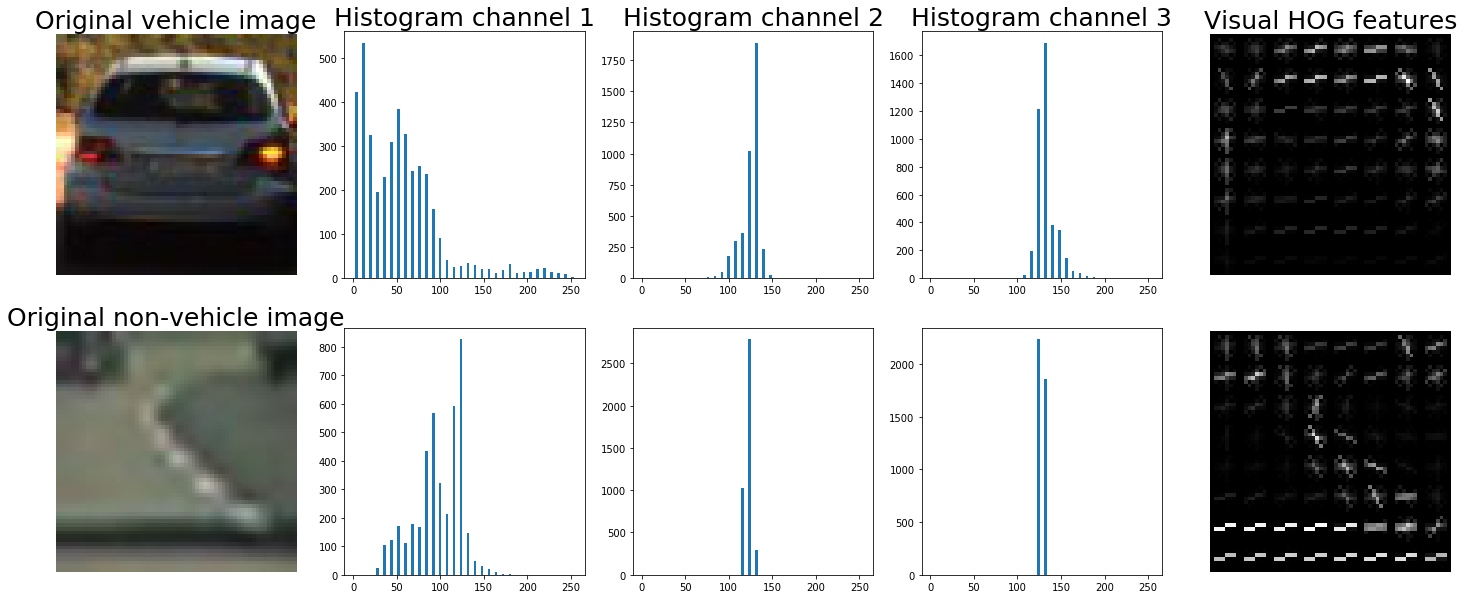

In [63]:
# visualize the feature extraction, features taken in YCrCb color space
veh_feat_sample_img = cv2.imread(vehicle_files[id_car])
veh_feat_sample_img = cv2.cvtColor(veh_feat_sample_img, cv2.COLOR_RGB2YCrCb)
non_feat_sample_img = cv2.imread(non_veh_files[id_non])
non_feat_sample_img = cv2.cvtColor(non_feat_sample_img, cv2.COLOR_RGB2YCrCb)

# spatial features not shown, these are very hard to interpret in YCrCb space

# color histogram features
veh_hist1 = np.histogram(veh_feat_sample_img[:,:,0], bins=hist_params['nbins'], range=hist_params['range'])
veh_hist2 = np.histogram(veh_feat_sample_img[:,:,1], bins=hist_params['nbins'], range=hist_params['range'])
veh_hist3 = np.histogram(veh_feat_sample_img[:,:,2], bins=hist_params['nbins'], range=hist_params['range'])
non_hist1 = np.histogram(non_feat_sample_img[:,:,0], bins=hist_params['nbins'], range=hist_params['range'])
non_hist2 = np.histogram(non_feat_sample_img[:,:,1], bins=hist_params['nbins'], range=hist_params['range'])
non_hist3 = np.histogram(non_feat_sample_img[:,:,2], bins=hist_params['nbins'], range=hist_params['range'])
hist_edges   = veh_hist1[1]
hist_centers = (hist_edges[1:]  + hist_edges[0:len(hist_edges)-1])/2

# hog image (taking only first image color channel as an example)
_, veh_img_hog = get_hog_features(veh_feat_sample_img, hog_params['cspace'], channel=1, orient=hog_params['orient'],
                                  pix_per_cell=hog_params['pix_per_cell'],
                                  cell_per_block=hog_params['cell_per_block'], vis=True, feature_vec=True)
_, non_img_hog = get_hog_features(non_feat_sample_img, hog_params['cspace'], channel=1, orient=hog_params['orient'],
                                  pix_per_cell=hog_params['pix_per_cell'],
                                  cell_per_block=hog_params['cell_per_block'], vis=True, feature_vec=True)

# visualize the features
fig, plts = plt.subplots(2, 5, figsize=(25,10))
plts[0, 0].imshow(cv2.imread(vehicle_files[id_car])[:,:,::-1])
plts[0, 0].axis('off'); plts[0, 0].set_title('Original vehicle image', fontsize=25)
plts[1, 0].imshow(cv2.imread(non_veh_files[id_non])[:,:,::-1])
plts[1, 0].axis('off'); plts[1, 0].set_title('Original non-vehicle image', fontsize=25)

plts[0, 1].bar(hist_centers, veh_hist1[0], width=3)
plts[0, 1].set_title('Histogram channel 1', fontsize=25)
plts[1, 1].bar(hist_centers, non_hist1[0], width=3)
plts[0, 2].bar(hist_centers, veh_hist2[0], width=3)
plts[0, 2].set_title('Histogram channel 2', fontsize=25)
plts[1, 2].bar(hist_centers, non_hist2[0], width=3)
plts[0, 3].bar(hist_centers, veh_hist3[0], width=3)
plts[0, 3].set_title('Histogram channel 3', fontsize=25)
plts[1, 3].bar(hist_centers, non_hist3[0], width=3)

plts[0, 4].imshow(veh_img_hog, cmap='gray'); plts[0, 4].axis('off')
plts[0, 4].set_title('Visual HOG features', fontsize=25)
plts[1, 4].imshow(non_img_hog, cmap='gray'); plts[1, 4].axis('off')

fig.savefig('output_images/features.jpg')
plt.show()

### shuffle, split & normalize

In [ ]:
# hyperparameters
val_size = 0.2 # fraction of data separated into valiation set

# just in case shuffle, although shouldn't be necessary because train_test_split() includes shuffling as well
X, y = shuffle(X, y)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_size)

# create normalizer based on *only* training data
feat_scaler = StandardScaler().fit(X_train)

# normalize training and validation set
X_train = feat_scaler.transform(X_train);
X_val   = feat_scaler.transform(X_val);
print('Amount of training samples: {}, amount of validation samples: {}'.format(
    X_train.shape[0], X_val.shape[0]))

### train classifier
use GridSearchCV() to automatically check optimize for hyperparameters

In [ ]:
# WATCH OUT, INCLUDING ALL THESE FEATURES IN A GRID SEARCH TAKES FOREVER, SLOWLY NARROW THE SEARCH INSTEAD

hyper_params = {'kernel': ('linear', 'poly', 'rbf', 'sigmoid'),
              'C':        [0.001, 0.05, 0.1, 0.5, 1, 10, 100],
              'gamma':    [0.001, 0.05, 0.1, 0.5, 1, 10, 100]}
svc = svm.SVC()

hyper_params = {'C': [0.001, 0.05, 0.1, 0.5, 1]}
svc = svm.LinearSVC()

clf = GridSearchCV(svc, hyper_params)

# train for all hyper parameter combinations
tic = time.time()
clf.fit(X_train, y_train)
print('Training for all hyperparameter combinations took {:.0f} minutes'.format((time.time()-tic)/60))
print('Optimal parameters for classifier are ', clf.best_params_)

### validate classifier

In [ ]:
print('Validation accuracy: {:.3f}'.format(clf.score(X_val, y_val)))

### Store classifier and scaler for future testing

In [ ]:
model_data = {}
model_data['classifier'] = clf
model_data['preprocessing_feature_scaler'] = feat_scaler
model_data['feature_params'] = feat_params_dict
pickle.dump(model_data, open('model_data/linear_full_255.p', 'wb'))

# Testing
### Load classifier and corresponding scaler and parameters

In [47]:
# load in pre-trained classifier and parameters
model = 'linear_full_255.p' # linear_best.p, poly_best.p

model_data       = pickle.load(open('model_data/'+model, 'rb'))
clf              = model_data['classifier']
feat_scaler      = model_data['preprocessing_feature_scaler']
feat_params_dict = model_data['feature_params']
cspace           = feat_params_dict['cspace']
spatial_params   = feat_params_dict['spatial']
hist_params      = feat_params_dict['hist']
hog_params       = feat_params_dict['hog']
#print('used parameters for current classifier: \'gamma\': {}, \'C\': {}'.format(clf.C, clf.C))
print('used parameters for current classifier: {}'.format(clf.best_params_))
#if X_val is not None: print('Validation accuracy: {:.3f}'.format(clf.score(X_val, y_val)))

used parameters for current classifier: {'C': 0.001}


### get testing features
Since we want to test the classifier on much bigger pictures, and since many random patches within the full test image could contain a car, we will slide a window over the image to obtain the right amount of features at every location and test whether it contains a car. These windows can be taken also at different scales.

For this functionality (including the car yes-or-no prediction, the below get_hot_bboxes() function is very useful

In [23]:
def get_hot_bboxes(img, cspace, bboxes_params, clf, feat_scaler,
                   spatial_params, hist_params, hog_params, confidence_thresh, verbose=False):
    
    # classifier was trained on 64x64 images
    window = 64
    
    # get correct color space
    color_dict = {"HLS":   cv2.COLOR_BGR2HLS,
                  "HSV":   cv2.COLOR_BGR2HSV,
                  "RGB":   cv2.COLOR_BGR2RGB,
                  "LUV":   cv2.COLOR_BGR2LUV,
                  "YCrCb": cv2.COLOR_BGR2YCrCb
                 }
    if cspace != 'BGR': img = cv2.cvtColor(img, color_dict[cspace])
    
    # get current image region of interest params
    idx     = bboxes_params['idx']
    y_start = bboxes_params['y_start'][idx]
    x_start = bboxes_params['x_start'][idx]
    y_stop  = bboxes_params['y_stop'][idx]
    x_stop  = bboxes_params['x_stop'][idx]
    scale   = bboxes_params['scales'][idx]
    
    # crop out region of interest (often the top half of an image wont include any cars)
    img_tosearch = img[y_start:y_stop,x_start:x_stop,:]
    img_shape    = img_tosearch.shape
        
    # rescale if required
    if scale != 1:
        img_tosearch = cv2.resize(img_tosearch, (np.int(img_shape[1]/scale), np.int(img_shape[0]/scale)))
        img_shape    = img_tosearch.shape
    
    #### pre-calculation in order to optimize the hog feature calculation to once per image ####
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    orient         = hog_params['orient']
    pix_per_cell   = hog_params['pix_per_cell']
    cell_per_block = hog_params['cell_per_block']
    
    # Define number of blocks within region of interest, and number of steps to iterate over valid patches
    nxblocks           = (img_shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks           = (img_shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block    = orient*cell_per_block**2
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    nxsteps            = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps            = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute HOG features for each color space in the entire image once
    hog_full_1 = get_hog_features(img_tosearch, output_space=hog_params['cspace'], channel=1,
                                  orient=hog_params['orient'], pix_per_cell=hog_params['pix_per_cell'],
                                  cell_per_block=hog_params['cell_per_block'], vis=False, feature_vec=False)
    hog_full_2 = get_hog_features(img_tosearch, output_space=hog_params['cspace'], channel=2,
                                  orient=hog_params['orient'], pix_per_cell=hog_params['pix_per_cell'],
                                  cell_per_block=hog_params['cell_per_block'], vis=False, feature_vec=False)
    hog_full_3 = get_hog_features(img_tosearch, output_space=hog_params['cspace'], channel=3,
                                  orient=hog_params['orient'], pix_per_cell=hog_params['pix_per_cell'],
                                  cell_per_block=hog_params['cell_per_block'], vis=False, feature_vec=False)
    
    # initialize list to contain all positive predicted bounding boxes
    hot_bboxes = []
    num_boxes  = 0
    
    # loop over all possible windows (with the current scale) in the image
    for xb in range(nxsteps):
        for yb in range(nysteps):
            num_boxes += 1
            ypos  = yb*cells_per_step
            xpos  = xb*cells_per_step
            ytop  = ypos*pix_per_cell
            xleft = xpos*pix_per_cell
            
            # extract the image patch pixels
            img_patch = img_tosearch[ytop:ytop+window, xleft:xleft+window]
            
            
            # spatial color features
            if spatial_params['use']: spa_feat  = bin_spatial(img_patch, output_space=spatial_params['cspace'],
                                                           size=spatial_params['size'])
        
            # colorchannel histogram features
            if hist_params['use']: hist_feat = color_hist(img_patch, output_space=hist_params['cspace'],
                                                       nbins=hist_params['nbins'], bins_range=hist_params['range'])
            
            # HOG features
            # calculating the HOG features only once for the full image
            # can help a lot in terms of computational requirements
            # However, something is still wrong with the implementation
            #hog_feat  = []
            #hog_feat.extend(hog_full_1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel())
            #hog_feat.extend(hog_full_2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel())
            #hog_feat.extend(hog_full_3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel())
            
            if hog_params['use']: hog_feat = get_hog_features(img_patch, output_space=hog_params['cspace'],
                                                              channel='all',
                                                              orient=hog_params['orient'],
                                                              pix_per_cell=hog_params['pix_per_cell'],
                                                              cell_per_block=hog_params['cell_per_block'],
                                                              vis=False, feature_vec=True)
            
            combined_feat = np.array([])
            if spatial_params['use']: combined_feat = np.concatenate((combined_feat, spa_feat ))
            if hist_params['use']:    combined_feat = np.concatenate((combined_feat, hist_feat))
            if hog_params['use']:     combined_feat = np.concatenate((combined_feat, hog_feat ))
            
            # Scale features and make a prediction
            test_features   = feat_scaler.transform(combined_feat.reshape(1, -1))      
            test_prediction = clf.predict(test_features)
            test_confidence = clf.decision_function(test_features)
            
            # check whether there is a car included according to our classifier
            if (test_prediction == 1) & (test_confidence > confidence_thresh):
            #if True:
                #print(test_confidence)
                #plt.imshow(img_patch)
                #plt.show()
                
                # if so, append the current box to the hot bounding boxes list
                bbox_left = int(xleft*scale)
                bbox_up   = int(ytop*scale)
                win_size  = int(window*scale)
                hot_bboxes.append(((bbox_left+x_start, bbox_up+y_start),
                                   (bbox_left+win_size+x_start, bbox_up+win_size+y_start)))
    
    if verbose: print('Number of boxes at scale {}: {}'.format(scale, num_boxes))
    return hot_bboxes

# boxes drawing function, usefull for visualizing identified hot boxes
def draw_boxes(img, bboxes, color=(255, 0, 0), thick=6):
    draw_img = np.copy(img)
    for bb in bboxes:
        cv2.rectangle(draw_img, bb[0], bb[1], color, thick)
    return draw_img

Number of boxes at scale 1: 285
Number of boxes at scale 2: 108
Number of boxes at scale 3: 17


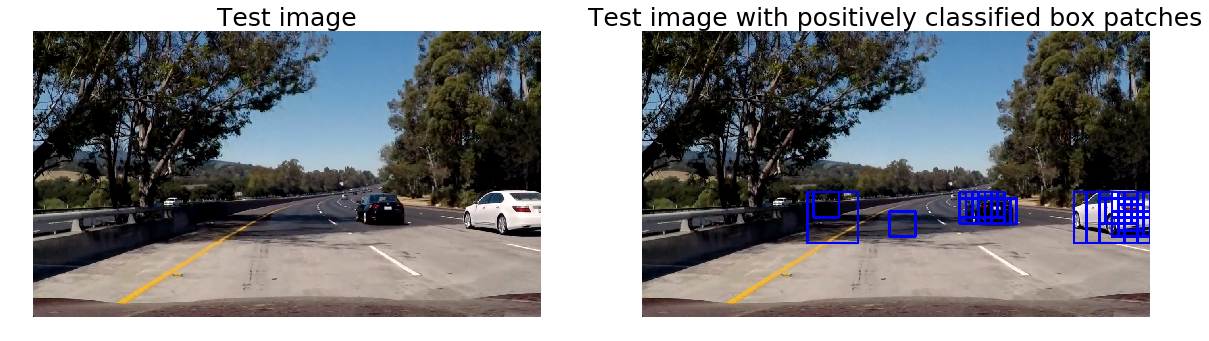

In [35]:
# load in a test image for shape details
test_img = cv2.imread('test_images/test5.jpg')
H, W     = test_img.shape[:2]

# Every prediction has a confidence, so we can set a threshold as well
confidence_thresh = 0.5

# hot bounding box function hyperparams
# Here we are cheating a little bit by shifting more boxes and thus the heavy lifting to the lower right corner,
# and limiting more computational requirements by not visiting the lower far left at all.
# We can do this because we know we are driving in a left lane and will mostly have cars to our ahead right.
# It is not unthinkable that a bigger self driving car pipelinehas this information, so I allow myself this benefit.
bboxes_params = {
    'idx':     0,
    'scales':  [1, 2, 3],
    'y_start': [int(H*18/32), int(H*9/16), int(H*9/16)],
    'x_start': [int(W*2/8),   int(W*8/32), int(W*8/32)],
    'y_stop':  [int(H*12/16), int(H*7/8),  int(H*7/8)],
    'x_stop':  [int(W*16/16), int(W*16/16),       W]}

# predict the bounding boxes containing a car
hot_bboxes   = []

for idx in range(len(bboxes_params['scales'])):
    bboxes_params['idx'] = idx
    hot_bboxes.extend(get_hot_bboxes(test_img, feat_params_dict['cspace'], bboxes_params, clf, feat_scaler,
                                     spatial_params, hist_params, hog_params, confidence_thresh, verbose=True)) 

# draw the boxes on the test image and count them
test_draw_boxes = draw_boxes(np.copy(test_img), hot_bboxes)
#print('Number of boxes used: {}'.format(len))


# visualize the identified bounding boxes
fig, plts = plt.subplots(1, 2, figsize=(20,10))
plts[0].imshow(test_img[:,:,::-1])
plts[0].axis('off'); plts[0].set_title('Test image', fontsize=25)
plts[1].imshow(test_draw_boxes[:,:,::-1])
plts[1].axis('off'); plts[1].set_title('Test image with positively classified box patches', fontsize=25)

#fig.savefig('output_images/hot_bboxes.jpg')
plt.show()

### Heatmap

In order to make sense out of all these boxes by combining and discarding some, a heat map approach is usefull.
First create a weighted mask according to the boxes. This mask can then be subjected to a threshold to filter out those parts of the image that are only present in (< threshold) positive bounding boxes. The sliding window approach will hopefully make sure that every part of the image corresponding to a car will be identified by multiple overlapping windows, and thus not be filtered out. Finally all the continuous patches in the thresholded mask are expected to identify a car.

In [30]:
def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    return heatmap

def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    
    return heatmap

def draw_labeled_heatmap(img, labels):
    # loop over all distinctly detected patches
    for car_number in range(1, labels[1]+1):
        # get pixel indices for current car_number
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        
        img = cv2.rectangle(img, bbox[0], bbox[1], (255,0,255), 6)
    return img

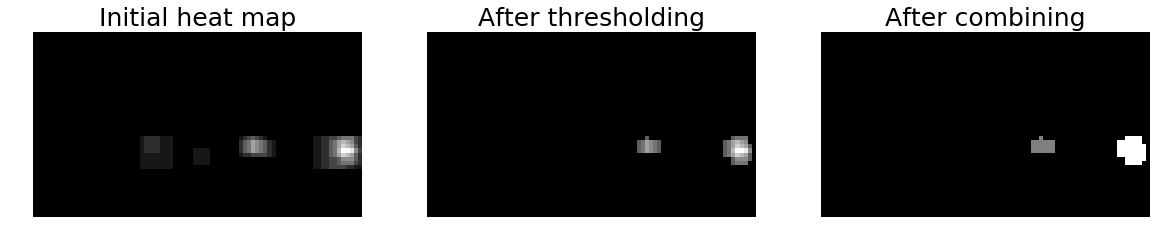

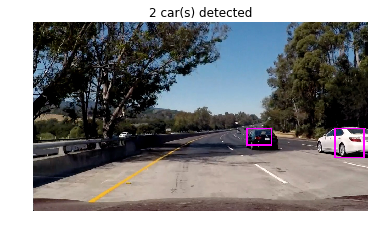

In [59]:
# heat map approach hyperparams
heat_threshold = 3

# intialize heat map
heat = np.zeros_like(test_img[:,:,0]).astype(np.uint16)
# add all positive box detections to the heat map
heat = add_heat(heat, hot_bboxes)
# threshold the heat map
heat_thresh = apply_threshold(np.copy(heat), heat_threshold)
# combine the resulting heat map into continuous patches with identifier, and get number of identifications
labels = label(heat_thresh)
num_car_det = labels[1]
# draw the resulting labels on the original test image
test_img_ann = draw_labeled_heatmap(np.copy(test_img), labels)

# Visualize the heat map approach
fig, plts = plt.subplots(1, 3, figsize=(20,10))
plts[0].imshow(heat, cmap='gray');      plts[0].axis('off');
plts[0].set_title('Initial heat map', fontsize=25)
plts[1].imshow(heat_thresh, cmap='gray'); plts[1].axis('off');
plts[1].set_title('After thresholding', fontsize=25)
plts[2].imshow(labels[0], cmap='gray'); plts[2].axis('off');
plts[2].set_title('After combining', fontsize=25)

fig.savefig('output_images/heat_map.jpg')
plt.show()

# Visualize the final output
plt.imshow(test_img_ann[:,:,::-1])
plt.title('{} car(s) detected'.format(num_car_det))
plt.axis('off')

plt.savefig('output_images/test_image_ann.jpg')
plt.show()

### temporal information leverage
In the videos we have not only single frame information, but also temporal information from frame to frame. The below class leverages this information by taking the added heat map of the last 'temporal_history' number of frames, and returning a thresholded version.  

In [39]:
# include a tracker to use temporal information to make the detection more robust
class track_labels():
    def __init__(self, H, W, threshold, temporal_history=7):
        self.heats     = []
        self.tracker   = 0
        self.size      = (H, W)
        self.threshold = threshold
        self.temp_hist = temporal_history
        self.average   = np.zeros(self.size).astype(np.uint16)
        for t in range(temporal_history):
            self.heats.append(np.zeros(self.size).astype(np.uint16))
    
    def __Clear(self, track):
        self.average     -= self.heats[track]
        self.heats[track] = np.zeros(self.size).astype(np.uint16)
    
    def __Update(self, hot_bboxes):
        self.__Clear(self.tracker)
        self.heats[self.tracker] = add_heat(self.heats[self.tracker], hot_bboxes)
        self.average += self.heats[self.tracker]
        self.tracker += 1
        if self.tracker == self.temp_hist: self.tracker = 0
        
    def GetHeat(self, hot_bboxes):
        self.__Update(hot_bboxes)
        #fig, plts = plt.subplots(1, 2, figsize=(20,10))
        #plts[0].imshow(self.average)
        #plts[1].imshow(apply_threshold(np.copy(self.average), self.threshold))
        #plt.show()
        
        return apply_threshold(np.copy(self.average), self.threshold)

### Full pipeline and video annotation

In [45]:
# create a full pipeline wrapper to easily call when annotating a video
def full_pipeline(img, cspace, bboxes_params, spatial_params, hist_params, hog_params,
                  clf, feat_scaler, heat_tracker, confidence_thresh):
    
    # loop over all the scales and get positively identified bounding boxes
    hot_bboxes = []
    for idx in range(len(bboxes_params['scales'])):
        bboxes_params['idx'] = idx
        hot_bboxes.extend(get_hot_bboxes(img, cspace, bboxes_params, clf, feat_scaler,
                                         spatial_params, hist_params, hog_params, confidence_thresh)) 
    
    # get heat map from track_labels object, and get labels
    heat_map = heat_tracker.GetHeat(hot_bboxes)
    labels   = label(heat_map)
    
    # draw the resulting label patched on the returning picture
    img_ann = draw_labeled_heatmap(img, labels)
    
    return img_ann, heat_tracker

In [46]:
# This is what it is all about: use our pipeline and annotate an entire video

# !!! BEFORE RUNNING THIS !!!
# make sure pickle with classifier, and all required functions and classes are loaded properly

# video size
H, W           = 720, 1280

# unpack all parameters
cspace         = feat_params_dict['cspace']
spatial_params = feat_params_dict['spatial']
hist_params    = feat_params_dict['hist']
hog_params     = feat_params_dict['hog']
bboxes_params = {
    'idx':     0,
    'scales':  [1, 2],
    'y_start': [int(H*18/32), int(H*9/16), int(H*9/16)],
    'x_start': [int(W*2/8),   int(W*8/32), int(W*8/32)],
    'y_stop':  [int(H*12/16), int(H*7/8),  int(H*7/8)],
    'x_stop':  [int(W*16/16), int(W*16/16),       W]}

# Define threshold for detection confidence and heat maps, and history length for heat maps
heat_map_time_frames = 15
heat_threshold       = 20
confidence_thresh    = 0.5

# Initialize track_labels object for vehicles tracking through time
heat_tracker = track_labels(H, W, threshold=heat_threshold, temporal_history=heat_map_time_frames)

# Choose which video to annotate, and get meta data
vid_file  = 'project_video' # 'test_video', 'project_video'
vid_in    = cv2.VideoCapture('videos/'+vid_file+'.mp4')
vid_len   = int(vid_in.get(cv2.CAP_PROP_FRAME_COUNT))
vid_W     = int(vid_in.get(cv2.CAP_PROP_FRAME_WIDTH))
vid_H     = int(vid_in.get(cv2.CAP_PROP_FRAME_HEIGHT))
vid_fps   =     vid_in.get(cv2.CAP_PROP_FPS)
vid_ind   = 1

# Initialize video writer
fourcc    = cv2.VideoWriter_fourcc(*'avc1')
vid_out   = cv2.VideoWriter('videos/'+vid_file+'_annotated_tp15_th20_ct05_sc1_2.mp4', fourcc, vid_fps, (vid_W, vid_H))

while(vid_in.isOpened()):
    # get next frame and check for end of video
    ret, frame = vid_in.read()
    if ret == False: break
    
    # keep track of frame index and print progress
    print('\rAnnotating frame {}/{}'.format(vid_ind, vid_len), end=''); vid_ind +=1
    # if vid_ind == 3: break
    if (vid_ind > 600): # & (vid_ind < 800):
    
        # annotate
        annotated, heat_tracker = full_pipeline(np.copy(frame), cspace, bboxes_params, spatial_params, hist_params,
                                            hog_params,
                                            clf, feat_scaler, heat_tracker, confidence_thresh)
        # store
        vid_out.write(annotated)

vid_in.release()
vid_out.release()

Annotating frame 1260/1260

In [64]:
HTML("""<video width="960" height="540" controls>
    <source src="{0}"></video>""".format('videos/'+vid_file+'_annotated.mp4'))

In [ ]:
test_img = load_img('test_images/video_0.jpg')
fig, plts = plt.subplots(1, 2, figsize=(20,10))
plts[0].imshow(frame);      plts[0].axis('off');
plts[1].imshow(test_img); plts[1].axis('off');
print(test_img-frame)
plt.show()

In [ ]:
vid_in.release()
vid_out.release()